In [44]:
import os
import pickle
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
import datetime
import urllib.request as req
from bs4 import BeautifulSoup

from pandas_datareader import data as pdr
import yfinance as yf

yf.pdr_override()

In [2]:
# JPXのETF一覧ページ
url = 'https://www.jpx.co.jp/equities/products/etfs/issues/01.html'

In [3]:
# 各商品の証券コードを取得
response = req.urlopen(url)
soup = BeautifulSoup(response, "html.parser")

attribute = []
div = soup.find('div', class_='component-normal-table')
table = div.find('table')
rows = table.find_all('tr')

tickers = []
for i, row in enumerate(rows):
    row_text = [td.get_text(strip=True) for td in row.select('th, td')]
    if i==0:
        continue
    tickers.append(row_text[1]+'.T')
print(len(tickers))


260


In [4]:
# 一年のうち取引が行われる日数
YEARLY_TRAIDING_DAYS = 252
# データ取得期間
START = pd.to_datetime('2012-01-01') 
END = pd.to_datetime('2022-12-31')

str_duration = START.strftime('%Y-%m-%d') + '_' + END.strftime('%Y-%m-%d')

f_tickers = 'data/tickers/' + str_duration + '_' +  'tickers.pickle'
f_returns = 'data/returns/' + str_duration + '_' +  'adj_close.csv'

In [5]:
tic = yf.Ticker('1305.T')
tic.info

{'phone': '+81-3-5555-3111',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 2455.0,
 'open': 2463.0,
 'dayLow': 2450.0,
 'dayHigh': 2474.5,
 'regularMarketPreviousClose': 2455.0,
 'regularMarketOpen': 2463.0,
 'regularMarketDayLow': 2450.0,
 'regularMarketDayHigh': 2474.5,
 'trailingPE': 14.424674,
 'volume': 196260,
 'regularMarketVolume': 196260,
 'averageVolume': 302030,
 'averageVolume10days': 551296,
 'averageDailyVolume10Day': 551296,
 'bid': 2456.5,
 'ask': 2457.5,
 'bidSize': 0,
 'askSize': 0,
 'yield': 0.0207,
 'totalAssets': 8231914045440,
 'fiftyTwoWeekLow': 1912.5,
 'fiftyTwoWeekHigh': 2474.5,
 'fiftyDayAverage': 2309.32,
 'twoHundredDayAverage': 2121.6226,
 'navPrice': 2408.9,
 'currency': 'JPY',
 'ytdReturn': 0.2043522,
 'beta3Year': 0.95,
 'fundFamily': 'Daiwa Asset Management Co Ltd',
 'fundInceptionDate': 994809600,
 'legalType': 'Exchange Traded Fund',
 'threeYearAverageReturn': 0.15203491,
 'fiveYearAverageReturn': 0.0785195,
 'exchange': 'JPX',
 'quoteType': '

In [6]:
def get_valid_tickers_info(tickers):
    if os.path.isfile(f_tickers):
        with open(f_tickers, 'rb') as f:
            valid_tickers_info = pickle.load(f)
    else:
        valid_tickers_info = {}
        # 各証券についてデータを取得
        for ticker in tickers:
            # 取得期間に証券データが存在しない場合はパスする
            try:
                tic = yf.Ticker(ticker)
                info = tic.info
                firstTradeDate_jst = datetime.datetime.fromtimestamp(tic.history_metadata['firstTradeDate'])
            except:
                continue
            # 取得開始の時期に証券が公開されていない場合はパスする
            if firstTradeDate_jst > START:
                continue
            else:
                print('valid : ', ticker)
                valid_tickers_info[ticker] = info
        
        with open (f_tickers, 'wb') as f:
            pickle.dump(valid_tickers_info, f)
            
    return valid_tickers_info


valid_tickers_info = get_valid_tickers_info(tickers)

In [7]:
valid_tickers_info

{'1305.T': {'phone': '+81-3-5555-3111',
  'maxAge': 86400,
  'priceHint': 2,
  'previousClose': 2455.0,
  'open': 2463.0,
  'dayLow': 2450.0,
  'dayHigh': 2474.5,
  'regularMarketPreviousClose': 2455.0,
  'regularMarketOpen': 2463.0,
  'regularMarketDayLow': 2450.0,
  'regularMarketDayHigh': 2474.5,
  'trailingPE': 14.41587,
  'volume': 196010,
  'regularMarketVolume': 196010,
  'averageVolume': 302030,
  'averageVolume10days': 551296,
  'averageDailyVolume10Day': 551296,
  'bid': 2454.0,
  'ask': 2456.0,
  'bidSize': 0,
  'askSize': 0,
  'yield': 0.0207,
  'totalAssets': 8231914045440,
  'fiftyTwoWeekLow': 1912.5,
  'fiftyTwoWeekHigh': 2474.5,
  'fiftyDayAverage': 2309.32,
  'twoHundredDayAverage': 2121.6226,
  'navPrice': 2408.9,
  'currency': 'JPY',
  'ytdReturn': 0.2043522,
  'beta3Year': 0.95,
  'fundFamily': 'Daiwa Asset Management Co Ltd',
  'fundInceptionDate': 994809600,
  'legalType': 'Exchange Traded Fund',
  'threeYearAverageReturn': 0.15203491,
  'fiveYearAverageReturn': 0

In [8]:
valid_tickers = list(valid_tickers_info.keys())

In [9]:
# 終値のみを取得
def get_adjclose(tickers):
    if os.path.isfile(f_returns):
        data = pd.read_csv(f_returns)
    else:
        data =  pdr.get_data_yahoo(tickers, start=START, end=END)['Adj Close']
        data.to_csv(f_returns)
    return data

# 各商品の１日あたりの対数収益率を計算、対数を取るのは収益率を正規分布に落とし込むため
def calc_D_returns(data):
    returns = np.log(data/data.shift(1))
    return returns

    # N = data.shape[0]
    # list_rate_of_return_per_term = list()
    # for j in range(N - D + 1):
    #     start = j
    #     end = j + D - 1
    #     rate_of_return = np.divide(
    #         data[end] - data[start], data[start]
    #     )
    #     list_rate_of_return_per_term.append(rate_of_return)
    # print()
    # return list_rate_of_return_per_term



data_adjclose = get_adjclose(valid_tickers)
returns = calc_D_returns(data_adjclose)

data_adjclose.to_csv(f_returns)

[*********************100%***********************]  90 of 90 completed


<Axes: xlabel='Date'>

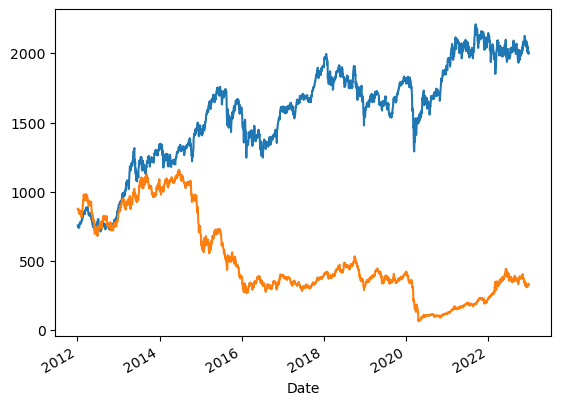

In [21]:
data_adjclose['1305.T'].plot()
data_adjclose['1699.T'].plot()

<Axes: xlabel='Date'>

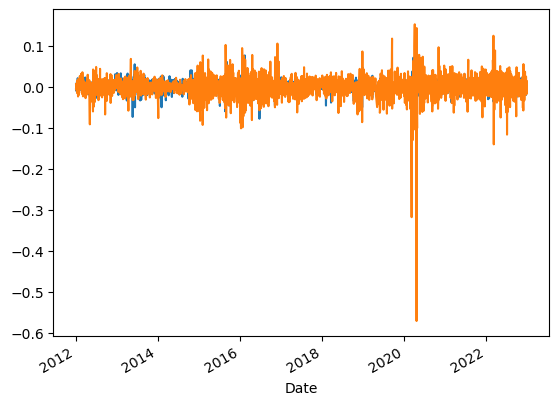

In [22]:
returns['1305.T'].plot()
returns['1699.T'].plot()

In [36]:
returns

,1305.T,1306.T,1308.T,1309.T,1311.T,1319.T,1320.T,1321.T,1322.T,1324.T,...,1690.T,1691.T,1692.T,1693.T,1694.T,1695.T,1696.T,1697.T,1698.T,1699.T
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,-0.006636,-0.006662,-0.008097,0.000000,-0.005208,0.007491,-0.004646,-0.003470,-0.005358,0.008969,...,-4.338702,-0.016950,-0.014318,-0.033785,-0.006324,-0.015385,0.019803,-4.362093,-0.009368,0.006857
2012-01-06,-0.009365,-0.010753,-0.012270,-0.001311,-0.010499,-0.007491,-0.009357,-0.014003,0.000000,-0.018019,...,-0.002186,0.005851,0.015963,-0.004216,0.004193,-0.015625,-0.013158,-0.010420,-0.013026,-0.006857
2012-01-10,0.002685,0.004046,0.004107,0.042368,0.005263,-0.022815,0.002347,0.003519,0.028113,0.018019,...,4.364419,0.005358,0.044471,-4.316498,0.038895,-0.007905,0.013158,4.372513,0.002381,-0.002296
2012-01-11,0.000000,0.000000,0.001365,0.000000,0.000000,-0.007722,0.000000,0.001170,0.002408,0.000000,...,-0.039370,-0.003315,-0.000108,4.337405,-0.003034,0.000000,-0.019803,-0.020907,0.007109,-0.002301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.002995,0.001768,0.003573,-0.002107,-0.002705,0.005134,0.003869,0.005883,-0.000685,0.000000,...,-0.004650,0.045133,-0.018205,0.007459,-0.006424,-0.002004,0.002876,-0.010926,0.003162,0.015305
2022-12-27,0.003483,0.005536,0.003307,0.015180,0.005402,0.008996,0.002571,0.002197,0.022619,0.000000,...,0.035792,0.008887,-0.007235,0.020063,0.023537,0.012955,0.004584,0.010421,0.002668,0.014475
2022-12-28,-0.001242,-0.002010,-0.000762,0.008020,-0.005294,-0.008996,-0.004780,-0.005319,0.004943,0.000000,...,0.003673,-0.014631,0.021092,0.004844,0.002733,0.011811,0.022054,0.035518,0.000242,0.001795


In [12]:
# 年次リターン
annual_returns = returns.mean()*YEARLY_TRAIDING_DAYS
# 各銘柄の共分散
cov_returns = returns.cov()*YEARLY_TRAIDING_DAYS

In [23]:
returns.mean()

1305.T    0.000360
1306.T    0.000357
1308.T    0.000358
1309.T    0.000343
1311.T    0.000321
1319.T    0.000338
1320.T    0.000422
1321.T    0.000422
1322.T    0.000408
1324.T   -0.000083
1325.T   -0.000031
1326.T    0.000234
1328.T    0.000184
1329.T    0.000426
1330.T    0.000421
1343.T    0.000307
1345.T    0.000303
1346.T    0.000422
1348.T    0.000355
1349.T    0.000151
1385.T    0.002043
1386.T    0.002030
1387.T    0.000242
1388.T   -0.001500
1389.T    0.003961
1390.T    0.001869
1393.T    0.005824
1394.T   -0.001418
1540.T    0.000229
1541.T    0.000059
1542.T    0.000096
1543.T    0.000546
1545.T    0.000778
1546.T    0.000558
1547.T    0.000621
1550.T    0.000509
1551.T    0.000477
1552.T   -0.002652
1554.T    0.000473
1555.T    0.000228
1557.T    0.000607
1559.T    0.000251
1560.T    0.000060
1563.T    0.000348
1615.T    0.000245
1617.T    0.000297
1618.T    0.000042
1619.T    0.000253
1620.T    0.000338
1621.T    0.000361
1622.T    0.000285
1623.T    0.000077
1624.T    0.

In [17]:
pd.set_option('display.max_rows', 100)
print(annual_returns)

1305.T    0.090840
1306.T    0.090068
1308.T    0.090115
1309.T    0.086334
1311.T    0.080783
1319.T    0.085062
1320.T    0.106309
1321.T    0.106415
1322.T    0.102705
1324.T   -0.020967
1325.T   -0.007863
1326.T    0.058868
1328.T    0.046343
1329.T    0.107377
1330.T    0.106059
1343.T    0.077476
1345.T    0.076248
1346.T    0.106284
1348.T    0.089421
1349.T    0.038171
1385.T    0.514895
1386.T    0.511488
1387.T    0.060929
1388.T   -0.377969
1389.T    0.998264
1390.T    0.470894
1393.T    1.467675
1394.T   -0.357290
1540.T    0.057771
1541.T    0.014799
1542.T    0.024166
1543.T    0.137701
1545.T    0.196116
1546.T    0.140564
1547.T    0.156531
1550.T    0.128382
1551.T    0.120195
1552.T   -0.668417
1554.T    0.119250
1555.T    0.057446
1557.T    0.152983
1559.T    0.063335
1560.T    0.015200
1563.T    0.087665
1615.T    0.061676
1617.T    0.074956
1618.T    0.010678
1619.T    0.063780
1620.T    0.085194
1621.T    0.090952
1622.T    0.071895
1623.T    0.019474
1624.T    0.

In [14]:
cov_returns

,1305.T,1306.T,1308.T,1309.T,1311.T,1319.T,1320.T,1321.T,1322.T,1324.T,...,1690.T,1691.T,1692.T,1693.T,1694.T,1695.T,1696.T,1697.T,1698.T,1699.T
1305.T,0.036518,0.036117,0.035684,0.021756,0.033133,0.022838,0.036744,0.036516,0.019984,0.023340,...,0.130945,-0.021106,0.008589,-0.102944,-0.045515,-0.064775,0.006663,0.051262,0.026214,0.027983
1306.T,0.036117,0.036973,0.036078,0.022038,0.033311,0.023453,0.036997,0.036919,0.020288,0.023192,...,0.168476,-0.013291,0.003920,-0.109385,-0.055239,-0.114498,0.006568,0.033916,0.026449,0.028086
1308.T,0.035684,0.036078,0.036331,0.021638,0.033162,0.022948,0.036631,0.036889,0.019898,0.023317,...,0.167911,-0.022069,0.008043,-0.117520,-0.057247,-0.086565,0.006816,0.019103,0.026468,0.027891
1309.T,0.021756,0.022038,0.021638,0.061053,0.021388,0.013220,0.024373,0.024520,0.041999,0.019280,...,0.204169,-0.062452,0.137249,-0.049508,-0.159812,0.002349,0.006810,-0.104770,0.016443,0.024661
1311.T,0.033133,0.033311,0.033162,0.021388,0.037509,0.022387,0.034295,0.034369,0.018865,0.022833,...,0.135859,0.030164,0.004631,-0.046928,-0.083476,-0.151263,0.007025,-0.005473,0.024744,0.028064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1695.T,-0.064775,-0.114498,-0.086565,0.002349,-0.151263,-0.231837,-0.085681,-0.080437,-0.022145,-0.055250,...,-1.090689,10.481281,-4.432785,-7.883988,21.396081,436.371424,0.047530,43.014747,-0.028925,0.026929
1696.T,0.006663,0.006568,0.006816,0.006810,0.007025,0.002288,0.007234,0.007077,0.006634,0.010955,...,-0.115703,0.122938,0.124528,0.114556,-0.257670,0.047530,0.094884,-0.006370,0.007267,0.026562
1697.T,0.051262,0.033916,0.019103,-0.104770,-0.005473,0.031281,0.091411,0.070086,-0.179644,-0.062492,...,-18.337012,8.289428,18.033627,23.450772,26.870445,43.014747,-0.006370,666.285879,0.100540,0.233819
1698.T,0.026214,0.026449,0.026468,0.016443,0.024744,0.018036,0.027365,0.027198,0.015699,0.018704,...,0.123439,0.000625,0.005764,0.088258,-0.130048,-0.028925,0.007267,0.100540,0.028427,0.023424


# 組合せ最適化

In [26]:
num_brand = len(valid_tickers)

## 最大投資口数 K
K = 100

## 共分散を考慮するパラメータ
gamma = 20

In [27]:
from amplify import BinarySymbolGenerator

# 変数の定義
x = BinarySymbolGenerator().array(num_brand, K)

# Unary法による非負整数wのバイナリ変数xによる表現
w = x.sum(axis=1)

In [28]:
from amplify import einsum


# 目的関数の定義
def setObjective(w, num_brand, expected_rate_of_return, variance_rate_of_return, gamma):
    """目的関数を定義
    ----------
    w: BinaryPolyArray
        各銘柄の購入口数を表す非負変数

    num_brand: int
        ポートフォリオを組む銘柄数

    expected_rate_of_return: np.ndarray
        期待収益率

    variance_rate_of_return: np.ndarray
        リスク分散

    gamma: float
        期待リスクの重要度を表すパラメータ

    Notes
    -----
    期待収益率の最大化と期待リスクの最小化
    期待収益率: E_w(R)
    期待リスク: V_w(R)
    目的関数 =  E_w(R) - gamma / 2 * V_w(R)
    """

    # 期待収益率の定義
    profit = einsum("i,i->", w, expected_rate_of_return)

    # 分散の定義
    risk = einsum("i,j,ij->", w, w, variance_rate_of_return)

    # 目的関数の定義
    objective = -profit + gamma * 0.5 * risk

    return objective, profit, risk

In [29]:
# 制約条件の定義
from amplify.constraint import equal_to


def setConstraint(w, K, num_brand):
    """制約式を定義

    Parameters
    ----------
    w: BinaryPoly
        各銘柄の購入口数を表す非負変数

    K: int
        全投資資産口数

    num_brand: int
        ポートフォリオを組む銘柄数

    Notes
    -----
    全投資資産はK口だけ
        \sum_{i=1}^n w_i = K
    """
    constraint = equal_to(w, K)

    return constraint

In [30]:
# ===================
# 目的関数と制約式の構築
# ===================
objective, _, _ = setObjective(
    w, num_brand, annual_returns.values, cov_returns.values, gamma
)
constraint = setConstraint(w, K, num_brand)

# 制約式の強さを表す係数
priority = 0.05

model = objective + priority * constraint

In [31]:
from amplify import Solver
from amplify.client import GurobiClient

client = GurobiClient()
# client.token = "DdYQS9jhLTCVAFJp4mQoCeHnwAKNeR3L" 
client.gurobi_path = "/Library/gurobi1001/macos_universal2/lib/libgurobi100.dylib"
client.parameters.time_limit = 10

# ソルバーを定義して実行
solver = Solver(client)
result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

# result配列にエネルギー値の昇順で解が格納される。よってresult[0]が最良の解。
energy, values = result[0].energy, result[0].values

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29
Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-29


In [32]:
def showSortedDataFrame(names, w_values, return_rates=None):
    """
    Parameters
    ----------
    names: list
        銘柄の名前

    return_rates: np.ndarray
        各銘柄の期待収益率

    w_values: BinaryPolyArray
        各銘柄の投資口数

    """
    if return_rates is None:
        df = pd.DataFrame(dict(brand_name=names, count=w_values.tolist()))
    else:
        df = pd.DataFrame(
            dict(brand_name=names, return_rate=return_rates, count=w_values.tolist())
        )

    # 投資口数が多い順にソート
    sorted_df = df.sort_values("count", ascending=False)

    # 表示する際には投資口数0の銘柄を表示しない
    display_df = sorted_df.query("count > 0")
    display(display_df.reset_index(drop=True))
    return display_df

In [34]:
# 各銘柄の投資口数が解である.
w_values = w.decode(result[0].values).astype(int)

# 投資口数の多い順に出力する
showSortedDataFrame(
    names=valid_tickers, return_rates=annual_returns.values*100, w_values=w_values
)

,brand_name,return_rate,count
0,1305.T,9.083966,100


,brand_name,return_rate,count
0,1305.T,9.083966,100


In [40]:
8.8/14.7

0.598639455782313

In [41]:
pr/risk

0.47536178830310283